In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import mixed_precision, layers
from tensorflow.keras.applications import EfficientNetB7,EfficientNetV2B3
mixed_precision.set_global_policy("mixed_float16")
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
import numpy as np
from tensorflow.keras.preprocessing import image
!pip install kaggle

In [19]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shubh556","key":"9a95da348a72d5b36991b3471d34e4f3"}'}

In [20]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [21]:
!kaggle datasets download -d shubh556/human-emotion-detection-dataset

 99% 194M/195M [00:11<00:00, 21.0MB/s]
100% 195M/195M [00:11<00:00, 18.5MB/s]


In [22]:
# Unzip the downloaded dataset
!unzip human-emotion-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Emotions Dataset/train/happy/557853.jpg_brightness_2.jpg  
  inflating: Emotions Dataset/train/happy/557853.jpg_rotation_1.jpg  
  inflating: Emotions Dataset/train/happy/558.jpg  
  inflating: Emotions Dataset/train/happy/558478.jpg  
  inflating: Emotions Dataset/train/happy/558478.jpg_brightness_1.jpg  
  inflating: Emotions Dataset/train/happy/558478.jpg_brightness_2.jpg  
  inflating: Emotions Dataset/train/happy/558478.jpg_rotation_1.jpg  
  inflating: Emotions Dataset/train/happy/559.jpg  
  inflating: Emotions Dataset/train/happy/559250.jpg  
  inflating: Emotions Dataset/train/happy/559250.jpg_brightness_2.jpg  
  inflating: Emotions Dataset/train/happy/559749.jpg_brightness_1.jpg  
  inflating: Emotions Dataset/train/happy/559749.jpg_rotation_2.jpg  
  inflating: Emotions Dataset/train/happy/56.jpg  
  inflating: Emotions Dataset/train/happy/560.jpg  
  inflating: Emotions Dataset/train/happy/560326.jpg  
  infla

In [23]:
test_data = "/content/Emotions Dataset/test"
train_data = "/content/Emotions Dataset/train"

In [ ]:
class_name = ['happy', 'angry', 'sad']

In [ ]:
train_directory=tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='int',
    class_names=class_name,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
)

Found 9650 files belonging to 3 classes.


In [ ]:
test_directory=tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels='inferred',
    label_mode='int',
    class_names=class_name,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
)

Found 2847 files belonging to 3 classes.


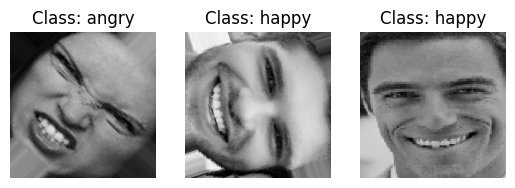

In [ ]:
import matplotlib.pyplot as plt


for images, labels in train_directory.take(1): 

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {class_name[labels[i]]}") 
        plt.axis("off")  
    plt.show()  


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224, 224),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
train_directory = train_directory.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_directory = test_directory.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

258076736/258076736 [==============================] - 7s 0us/step


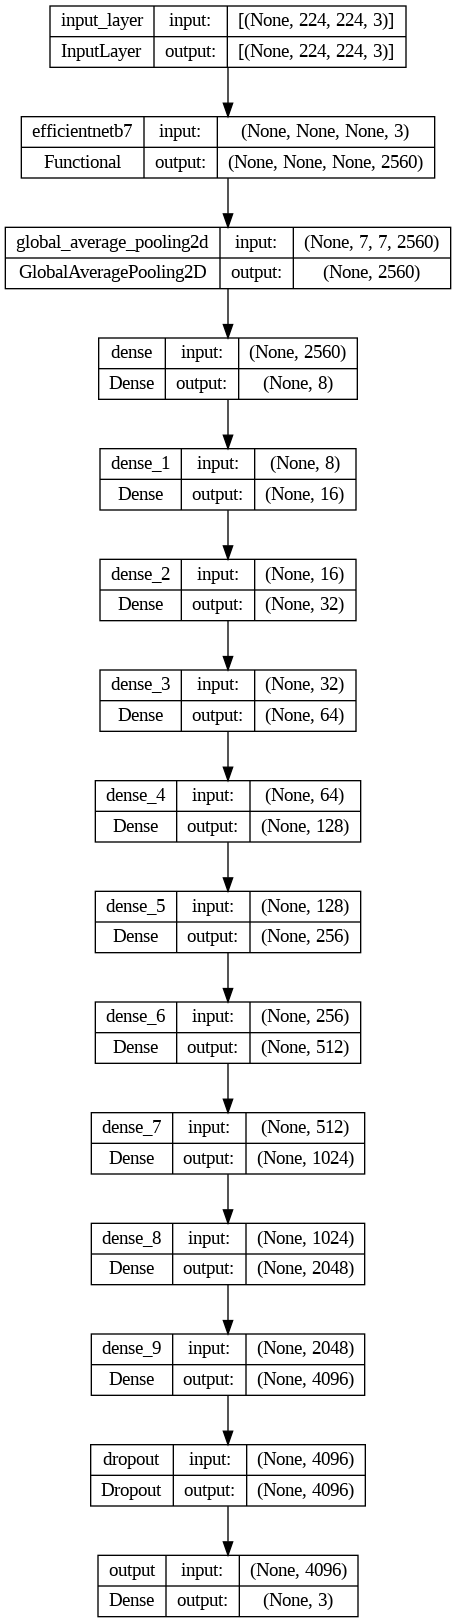

In [ ]:
num_classes = 3
input_shape = (224, 224, 3)
base_model = EfficientNetB7(include_top=False,weights='imagenet')
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(8)(x)
x = layers.Dense(16)(x)
x = layers.Dense(32)(x)
x = layers.Dense(64)(x)
x = layers.Dense(128)(x)
x = layers.Dense(256)(x)
x = layers.Dense(512)(x)
x = layers.Dense(1024)(x)
x = layers.Dense(2048)(x)
x = layers.Dense(4096)(x)
x = layers.Dropout(.1)(x)
outputs = layers.Dense(num_classes, activation='sigmoid', name='output')(x)
model = tf.keras.Model(inputs, outputs)
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
reduce_lr= tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-5,
                                                patience=0,
                                                verbose=1)
early_stopping = EarlyStopping(verbose=1, monitor="val_accuracy", patience=0, restore_best_weights=True)
plot_model(model, show_shapes=True)

In [ ]:
# unfrezze all the layers
base_model.trainable=True
#refrezze every layer except last 5
for layer in base_model.layers[:-5]:
    layer.trainable=False


In [ ]:
# Check which layers are trainable in the base model
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
rescaling_1 False
normalization False
rescaling_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block1c_dwconv False
block1c_bn False
block1c_activation False
block1c_se_squeeze False
block1c_se_reshape False
block1c_se_reduce False
block1c_se_expand False
block1c_se_excite False
block1c_project_conv False
block1c_project_bn False
block1c_drop False
block1c_add False
block1d_dwconv False
block1d_bn False
block1d_activation False
block1d_se

In [ ]:
feature_extract = model.fit(
    train_directory,
    epochs=30,
    validation_data=test_directory,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/30
302/302 [==============================] - 108s 266ms/step - loss: 0.8142 - accuracy: 0.6279 - val_loss: 0.7064 - val_accuracy: 0.6884 - lr: 1.0000e-04
Epoch 2/30
302/302 [==============================] - 75s 248ms/step - loss: 0.6872 - accuracy: 0.7022 - val_loss: 0.6640 - val_accuracy: 0.7165 - lr: 1.0000e-04
Epoch 3/30
302/302 [==============================] - 75s 248ms/step - loss: 0.6402 - accuracy: 0.7238 - val_loss: 0.6144 - val_accuracy: 0.7422 - lr: 1.0000e-04
Epoch 4/30
302/302 [==============================] - 75s 248ms/step - loss: 0.6077 - accuracy: 0.7403 - val_loss: 0.6013 - val_accuracy: 0.7468 - lr: 1.0000e-04
Epoch 5/30
302/302 [==============================] - 75s 248ms/step - loss: 0.5870 - accuracy: 0.7498 - val_loss: 0.5747 - val_accuracy: 0.7654 - lr: 1.0000e-04
Epoch 6/30
302/302 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7652
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Restoring model 

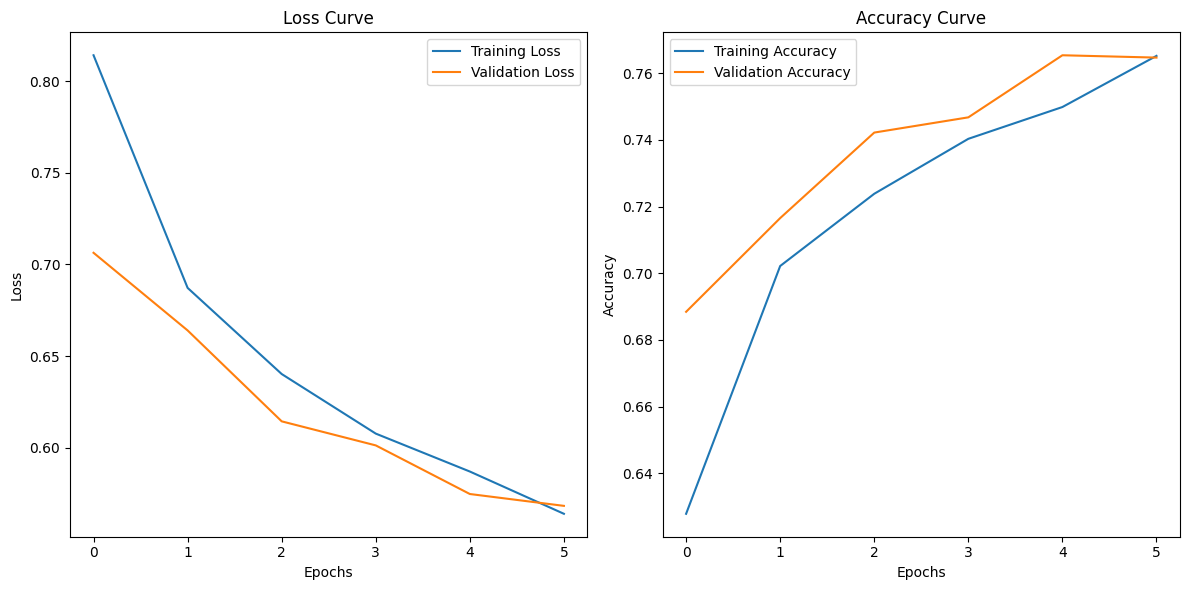

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(feature_extract.history['loss'], label='Training Loss')
plt.plot(feature_extract.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(feature_extract.history['accuracy'], label='Training Accuracy')
plt.plot(feature_extract.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
result=model.evaluate(test_directory)
result

89/89 [==============================] - 17s 187ms/step - loss: 0.5747 - accuracy: 0.7654


[0.5747063159942627, 0.7653670310974121]

89/89 [==============================] - 21s 183ms/step


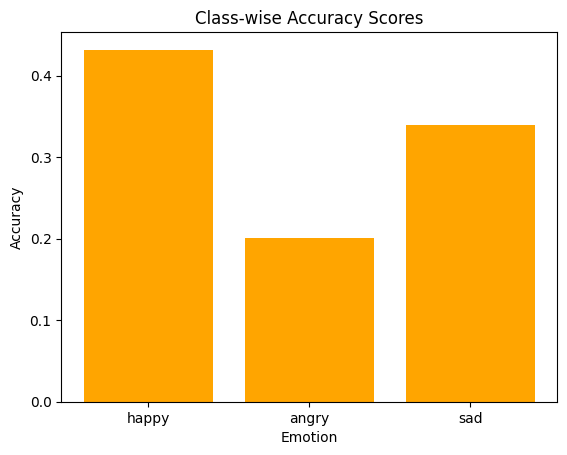

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_directory)

# Get the predictions for the test data
predictions = model.predict(test_directory)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = np.concatenate([y for x, y in test_directory], axis=0)

# Calculate accuracy for each class
class_accuracy = []
for i in range(num_classes):
    class_indices = np.where(true_labels == i)[0]
    class_accuracy.append(np.mean(predicted_classes[class_indices] == true_labels[class_indices]))

# Plot class-wise accuracy scores
plt.bar(class_name, class_accuracy, color='orange')
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy Scores')
plt.show()


In [ ]:
# model.save('/content/drive/My Drive/EF-Net-B7')